In [265]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = pd.read_excel('online_retail_II.xlsx')



In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [267]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [268]:
print(df.isnull().sum())

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64


In [269]:
# Removing rows with missing Customer ID
df.dropna(subset=['Customer ID'], inplace=True)

# Replacing missing values in Description
df['Description'].fillna('Missing Description', inplace=True)


In [270]:
print(df.isnull().sum())

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


In [271]:
# Removing duplicates
df.drop_duplicates(inplace=True)

# Converting InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Converting relevant columns to appropriate data types for good measure
df['Customer ID'] = df['Customer ID'].astype(int)
df['Invoice'] = df['Invoice'].astype(str)


In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410763 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      410763 non-null  object        
 1   StockCode    410763 non-null  object        
 2   Description  410763 non-null  object        
 3   Quantity     410763 non-null  int64         
 4   InvoiceDate  410763 non-null  datetime64[ns]
 5   Price        410763 non-null  float64       
 6   Customer ID  410763 non-null  int32         
 7   Country      410763 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 26.6+ MB


In [273]:
# Creating TotalCost feature
df['TotalCost'] = df['Price'] * df['Quantity']
# df['TotalCost'] = df['Price'] * df['Quantity'].abs()

# Dropping rows that indicate cancelled orders (meaning 0 for Quantity and 0.00 for TotalCost)
df = df.loc[~((df['Quantity'] <= 0) & (df['TotalCost'] <= 0.00))]

In [274]:
df.loc[:, 'InvoiceHour'] = df['InvoiceDate'].dt.hour
df.loc[:, 'InvoiceDayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df.loc[:, 'InvoiceMonth'] = df['InvoiceDate'].dt.month
df.loc[:, 'InvoiceYear'] = df['InvoiceDate'].dt.year

C:\Users\sidne\AppData\Local\Temp\ipykernel_996\3728494865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'InvoiceHour'] = df['InvoiceDate'].dt.hour
C:\Users\sidne\AppData\Local\Temp\ipykernel_996\3728494865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'InvoiceDayOfWeek'] = df['InvoiceDate'].dt.dayofweek
C:\Users\sidne\AppData\Local\Temp\ipykernel_996\3728494865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [275]:
# Calculating the Time Since Last Purchase in days
# Setting a Snapshot Date
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

# Identifying the Last Purchase Date for each customer
last_purchase_dates = df.groupby('Customer ID')['InvoiceDate'].max()

# Calculating the Time Difference
time_since_last_purchase = (snapshot_date - last_purchase_dates).dt.days

# Adding the "Time Since Last Purchase" feature to the dataset
df['TimeSinceLastPurchase (in days)'] = df['Customer ID'].map(time_since_last_purchase)

C:\Users\sidne\AppData\Local\Temp\ipykernel_996\3479624023.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TimeSinceLastPurchase (in days)'] = df['Customer ID'].map(time_since_last_purchase)


In [276]:
# Calculating RFM metrics
rfm_data = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalCost': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalCost': 'Monetary'
}).reset_index()

In [277]:
# Converting Recency column to datetime
rfm_data['Recency'] = pd.to_numeric(rfm_data['Recency'])

In [278]:
max_recency = rfm_data['Recency'].max()
max_frequency = rfm_data['Frequency'].max()
max_monetary = rfm_data['Monetary'].max()

print("Maximum Recency:", max_recency)
print("Maximum Frequency:", max_frequency)
print("Maximum Monetary:", max_monetary)

Maximum Recency: 374
Maximum Frequency: 205
Maximum Monetary: 349164.35


In [279]:
# Creating RFM score bins
recency_bins = [0, 80, 160, 240, 320, 400]
frequency_bins = [0, 50, 100, 150, 200, 250]
monetary_bins = [0, 70000, 140000, 210000, 280000, 350000]

rfm_data['R'] = pd.cut(rfm_data['Recency'], bins=recency_bins, labels=[4, 3, 2, 1, 0], right=False)
rfm_data['F'] = pd.cut(rfm_data['Frequency'], bins=frequency_bins, labels=[0, 1, 2, 3, 4], right=False)
rfm_data['M'] = pd.cut(rfm_data['Monetary'], bins=monetary_bins, labels=[0, 1, 2, 3, 4], right=False)

# Calculating the RFM score
rfm_data['RFM_Score'] = rfm_data[['R', 'F', 'M']].sum(axis=1)


In [280]:
# Creating RFM segments
rfm_data['RFM_Segment'] = rfm_data['R'].astype(str) + rfm_data['F'].astype(str) + rfm_data['M'].astype(str)
rfm_data['RFM_Score'] = rfm_data[['R', 'F', 'M']].sum(axis=1)

In [281]:
# Merging datasets
merged_df = pd.merge(df, rfm_data, on='Customer ID', how='left')

In [282]:
# Aggregating Features 
customer_agg = df.groupby('Customer ID').agg({
    'Invoice': 'nunique',
    'TotalCost': 'sum',
    'Quantity': 'sum'
}).rename(columns={
    'Invoice': 'TotalPurchases',
    'TotalCost': 'TotalMonetaryValue',
    'Quantity': 'TotalQuantity'
})

# Merging final data
final_data = pd.merge(merged_df, customer_agg, on='Customer ID', how='left')

In [283]:
final_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalCost,InvoiceHour,InvoiceDayOfWeek,InvoiceMonth,InvoiceYear,TimeSinceLastPurchase (in days),Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Segment,TotalPurchases,TotalMonetaryValue,TotalQuantity
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40,7,1,12,2009,315,315,6,2017.20,1,0,0,1,100,6,2017.20,728
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,7,1,12,2009,315,315,6,2017.20,1,0,0,1,100,6,2017.20,728
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,7,1,12,2009,315,315,6,2017.20,1,0,0,1,100,6,2017.20,728
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80,7,1,12,2009,315,315,6,2017.20,1,0,0,1,100,6,2017.20,728
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00,7,1,12,2009,315,315,6,2017.20,1,0,0,1,100,6,2017.20,728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400942,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom,5.90,20,3,12,2010,1,1,3,725.21,4,0,0,4,400,3,725.21,421
400943,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom,3.75,20,3,12,2010,1,1,3,725.21,4,0,0,4,400,3,725.21,421
400944,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom,3.75,20,3,12,2010,1,1,3,725.21,4,0,0,4,400,3,725.21,421
400945,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom,7.50,20,3,12,2010,1,1,3,725.21,4,0,0,4,400,3,725.21,421


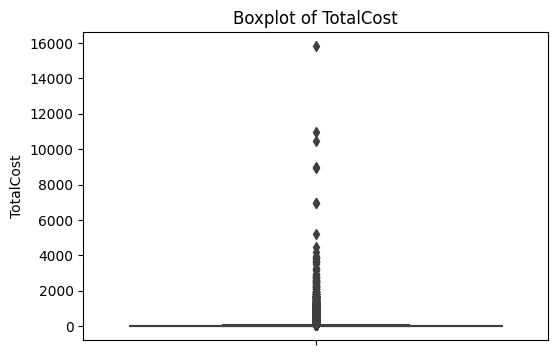

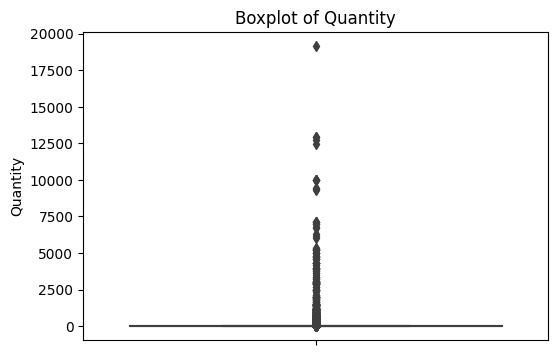

In [284]:
# Examining outliers
# Selecting numeric variables to examine for outliers
numeric_vars = ['TotalCost', 'Quantity']

# Creating boxplots for each numeric variable
for var in numeric_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, y=var)
    plt.title(f"Boxplot of {var}")
    plt.show()

# For the sake of documentation, the outliers observed were values of 0 for Quantity and negative values & 0.00 for both Price and TotalCost. Rows reflecting cancelled orders and returns were omitted for data integrity.

In [285]:
# Calculating descriptive statistics for each numeric variable
results = []

for var in numeric_vars:
    var_stats = df[var].describe()
    print(f"\nDescriptive Statistics for {var}:")
    result = print(var_stats)
    results.append(result)

# results_df = pd.DataFrame(results)
# results_df.to_csv('totalcost_stats.csv', index=True)


Descriptive Statistics for TotalCost:
count    400947.000000
mean         21.943633
std          77.755308
min           0.000000
25%           5.000000
50%          12.500000
75%          19.500000
max       15818.400000
Name: TotalCost, dtype: float64

Descriptive Statistics for Quantity:
count    400947.000000
mean         13.768523
std          97.639816
min           1.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       19152.000000
Name: Quantity, dtype: float64


In [286]:
sorted_dataset = final_data.sort_values('Quantity')
sorted_dataset

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalCost,InvoiceHour,InvoiceDayOfWeek,InvoiceMonth,InvoiceYear,TimeSinceLastPurchase (in days),Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Segment,TotalPurchases,TotalMonetaryValue,TotalQuantity
146323,508469,47566,PARTY BUNTING,1,2010-05-16 10:59:00,4.65,17377,United Kingdom,4.65,10,6,5,2010,1,1,60,14174.25,4,1,0,5,410,60,14174.25,5486
181670,512895,85049B,LUSH GREENS RIBBONS,1,2010-06-18 12:45:00,1.25,15031,United Kingdom,1.25,12,4,6,2010,30,30,10,2449.75,4,0,0,4,400,10,2449.75,1176
181671,512895,85049E,SCANDINAVIAN REDS RIBBONS,1,2010-06-18 12:45:00,1.25,15031,United Kingdom,1.25,12,4,6,2010,30,30,10,2449.75,4,0,0,4,400,10,2449.75,1176
181672,512895,85049F,BABY BOOM RIBBONS,1,2010-06-18 12:45:00,1.25,15031,United Kingdom,1.25,12,4,6,2010,30,30,10,2449.75,4,0,0,4,400,10,2449.75,1176
67587,498552,22194,BLACK DINER WALL CLOCK,1,2010-02-21 10:25:00,8.50,17243,United Kingdom,8.50,10,6,2,2010,5,5,44,11920.43,4,0,0,4,400,44,11920.43,4704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90470,501534,21092,SET/6 STRAWBERRY PAPER PLATES,12480,2010-03-17 13:09:00,0.10,13902,Denmark,1248.00,13,2,3,2010,268,268,5,34095.26,1,0,0,1,100,5,34095.26,220600
90472,501534,21085,SET/6 WOODLAND PAPER CUPS,12744,2010-03-17 13:09:00,0.10,13902,Denmark,1274.40,13,2,3,2010,268,268,5,34095.26,1,0,0,1,100,5,34095.26,220600
90471,501534,21091,SET/6 WOODLAND PAPER PLATES,12960,2010-03-17 13:09:00,0.10,13902,Denmark,1296.00,13,2,3,2010,268,268,5,34095.26,1,0,0,1,100,5,34095.26,220600
90469,501534,21099,SET/6 STRAWBERRY PAPER CUPS,12960,2010-03-17 13:09:00,0.10,13902,Denmark,1296.00,13,2,3,2010,268,268,5,34095.26,1,0,0,1,100,5,34095.26,220600


In [287]:
# Correlation analysis
correlation = df['Quantity'].corr(df['TotalCost'])
print("Correlation coefficient:", correlation)

Correlation coefficient: 0.4142019334232178


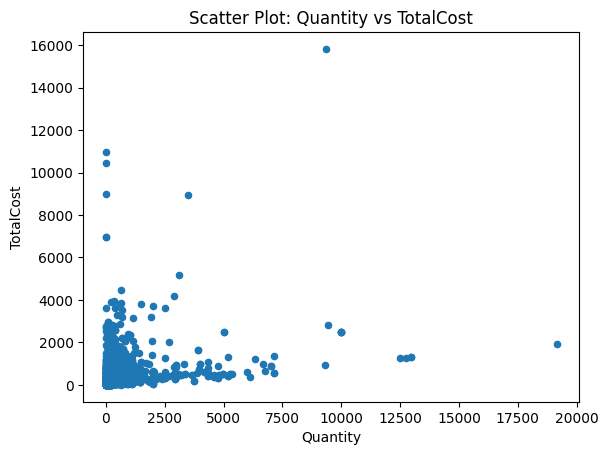

In [288]:
# Continuing correlation analysis with scatter plot visualization
df.plot.scatter(x='Quantity', y='TotalCost')
plt.xlabel('Quantity')
plt.ylabel('TotalCost')
plt.title('Scatter Plot: Quantity vs TotalCost')
plt.show()

In [289]:
# Grouped analysis
country_totals = df.groupby('Country')['TotalCost'].describe().sort_values(by='count', ascending=False)
print("The descriptive statistics for Customer Order Total Cost is\n", country_totals)

The descriptive statistics for Customer Order Total Cost is
                          count        mean         std   min      25%     50%  \
Country                                                                         
United Kingdom        364255.0   20.265046   74.570396  0.00   4.3200  10.500   
EIRE                    8503.0   41.872499  105.200202  1.65  14.8500  17.700   
Germany                 7652.0   26.401645   33.872945  0.00  13.2000  17.400   
France                  5452.0   26.798802   68.493294  0.42  11.8000  16.500   
Netherlands             2729.0   98.491883  137.785666  0.00  14.8500  50.400   
Spain                   1228.0   38.736686  103.014235  0.42  10.2000  15.600   
Switzerland             1170.0   37.539650   49.650240  4.32  15.0000  19.800   
Belgium                 1037.0   23.662083   50.364586  0.00  13.2000  17.400   
Portugal                 983.0   24.255809   29.892381  0.84  13.2000  17.000   
Sweden                   867.0   61.301027   92.

In [290]:
# Continued grouped analysis
country_quant = df.groupby('Country')['Quantity'].describe().sort_values(by='count', ascending=False)
print("The descriptive statistics for Order Quantity is\n", country_quant)

The descriptive statistics for Order Quantity is
                          count        mean          std  min    25%   50%  \
Country                                                                     
United Kingdom        364255.0   12.164352    67.994102  1.0   2.00   4.0   
EIRE                    8503.0   21.335176    54.557630  1.0   4.00  10.0   
Germany                 7652.0   14.196681    22.115567  1.0   6.00  12.0   
France                  5452.0   29.722671   242.504216  1.0   6.00  10.0   
Netherlands             2729.0   67.306339    92.085192  1.0   8.00  24.0   
Spain                   1228.0   18.600163    52.077138  1.0   4.00  10.0   
Switzerland             1170.0   19.021368    23.325393  1.0   6.00  12.0   
Belgium                 1037.0   11.638380    11.559373  1.0   6.00  10.0   
Portugal                 983.0   12.195320    11.981082  1.0   6.00  10.0   
Sweden                   867.0   60.457901   134.984026  1.0   8.00  12.0   
Channel Islands          8

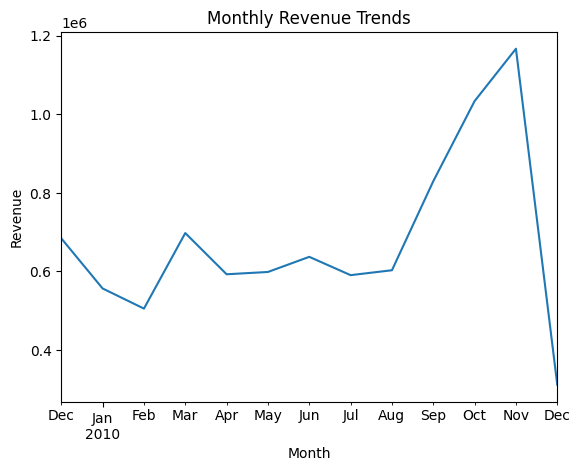

In [291]:
# Exploring monthly revenue trends
monthly_revenue = df.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalCost'].sum()
monthly_revenue.plot(kind='line')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue Trends')
plt.show()

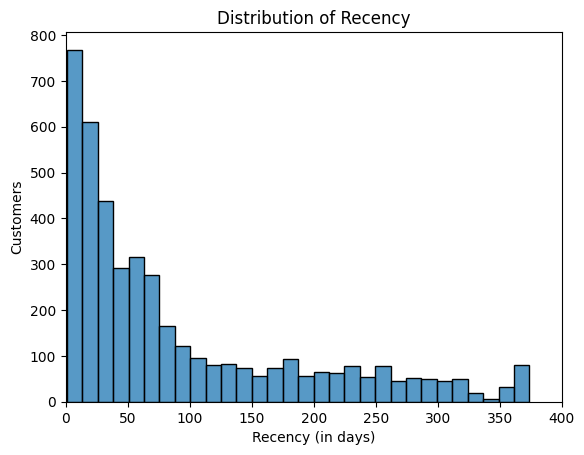

In [314]:
# Visualize RFM distributions
sns.histplot(rfm_data['Recency'], bins=30)
plt.xlabel('Recency (in days)')
plt.ylabel('Customers')
plt.title('Distribution of Recency')
plt.xlim(0, 400)
plt.show()

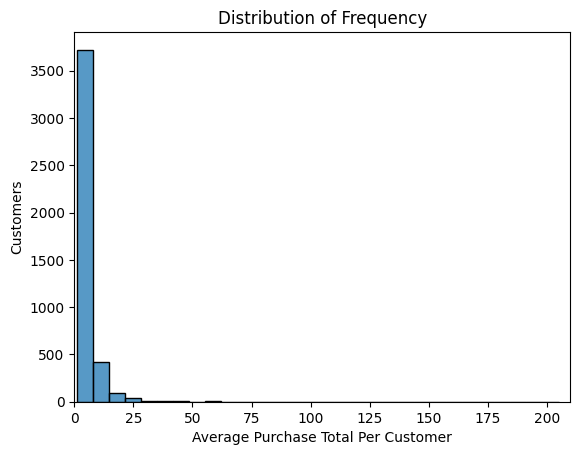

In [315]:
# Visualize RFM distributions
sns.histplot(rfm_data['Frequency'], bins=30)
plt.xlabel('Average Purchase Total Per Customer')
plt.ylabel('Customers')
plt.title('Distribution of Frequency')
plt.xlim(0, 210)
plt.show()

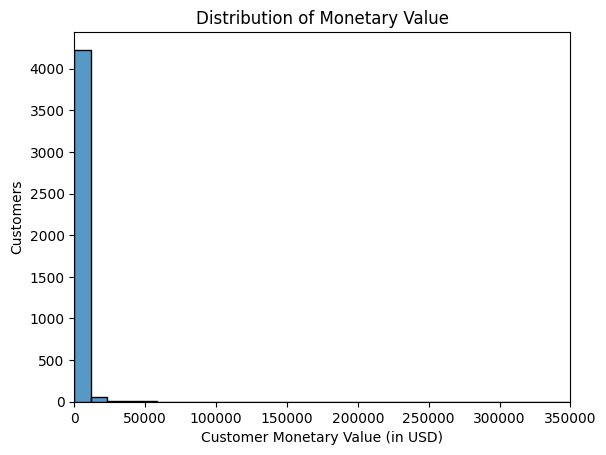

In [317]:
# Visualize RFM distributions
sns.histplot(rfm_data['Monetary'], bins=30)
plt.xlabel('Customer Monetary Value (in USD)')
plt.ylabel('Customers')
plt.title('Distribution of Monetary Value')
plt.xlim(0, 350000)
plt.show()

In [295]:
highest_monetary = sorted_dataset['Monetary'].max()
print("Highest Monetary Value:", highest_monetary)

Highest Monetary Value: 349164.35


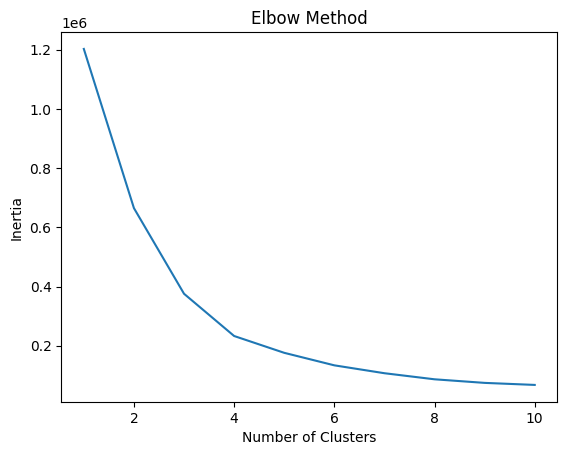

In [296]:
# K-means clustering

features = sorted_dataset[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Elbow Method to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Elbow Method graph
import matplotlib.pyplot as plt
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [297]:
# Apply K-means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
kmeans.fit(scaled_features)

# Getting cluster labels
cluster_labels = kmeans.labels_

# Adding the cluster labels to the original dataframe
sorted_dataset['Cluster'] = cluster_labels


In [298]:
# Explore each customer segment
segment_summary = sorted_dataset.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'count'
}).rename(columns={'Customer ID': 'Count'})
# segment_summary.to_csv("segment_summary.csv", index=True)
header_row = 1
dfseg = pd.DataFrame(segment_summary)
# df.columns.values[0] = df.iloc[1, 0]
# df = df.drop(1)
# print(segment_summary)
dfseg

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,28.232217,9.810315,4558.611797,325609
1,4.413239,146.514431,186005.369537,11572
2,208.644449,4.285563,1666.236208,39564
3,2.837617,99.381704,35684.969932,24202


In [299]:
cluster_avg = sorted_dataset.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_avg)

            Recency   Frequency       Monetary
Cluster                                       
0         28.232217    9.810315    4558.611797
1          4.413239  146.514431  186005.369537
2        208.644449    4.285563    1666.236208
3          2.837617   99.381704   35684.969932


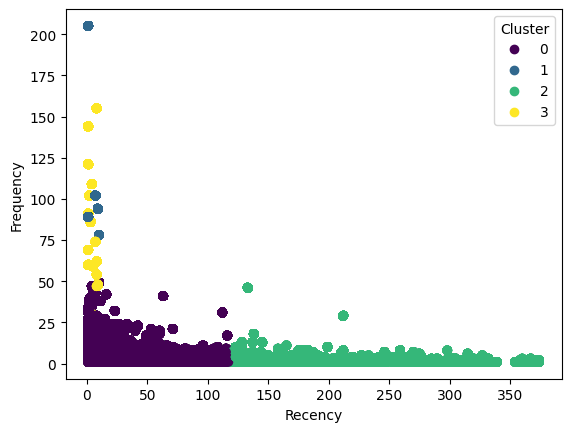

In [300]:
# Scatter plot 
scatter = plt.scatter(sorted_dataset['Recency'], sorted_dataset['Frequency'], c=sorted_dataset['Cluster'])

plt.legend(*scatter.legend_elements(), title='Cluster')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

In [301]:
# Dictionary to map old cluster labels to new names
cluster_names = {
    3: "Active & Valuable Customers",
    2: "Occasional Shoppers",
    1: "High-Value Engaged Customers",
    0: "Moderate-Value Customers"
}

# Rename the cluster labels in the DataFrame
sorted_dataset['Cluster'] = sorted_dataset['Cluster'].map(cluster_names)
sorted_dataset


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalCost,InvoiceHour,InvoiceDayOfWeek,InvoiceMonth,InvoiceYear,TimeSinceLastPurchase (in days),Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Segment,TotalPurchases,TotalMonetaryValue,TotalQuantity,Cluster
146323,508469,47566,PARTY BUNTING,1,2010-05-16 10:59:00,4.65,17377,United Kingdom,4.65,10,6,5,2010,1,1,60,14174.25,4,1,0,5,410,60,14174.25,5486,Active & Valuable Customers
181670,512895,85049B,LUSH GREENS RIBBONS,1,2010-06-18 12:45:00,1.25,15031,United Kingdom,1.25,12,4,6,2010,30,30,10,2449.75,4,0,0,4,400,10,2449.75,1176,Moderate-Value Customers
181671,512895,85049E,SCANDINAVIAN REDS RIBBONS,1,2010-06-18 12:45:00,1.25,15031,United Kingdom,1.25,12,4,6,2010,30,30,10,2449.75,4,0,0,4,400,10,2449.75,1176,Moderate-Value Customers
181672,512895,85049F,BABY BOOM RIBBONS,1,2010-06-18 12:45:00,1.25,15031,United Kingdom,1.25,12,4,6,2010,30,30,10,2449.75,4,0,0,4,400,10,2449.75,1176,Moderate-Value Customers
67587,498552,22194,BLACK DINER WALL CLOCK,1,2010-02-21 10:25:00,8.50,17243,United Kingdom,8.50,10,6,2,2010,5,5,44,11920.43,4,0,0,4,400,44,11920.43,4704,Moderate-Value Customers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90470,501534,21092,SET/6 STRAWBERRY PAPER PLATES,12480,2010-03-17 13:09:00,0.10,13902,Denmark,1248.00,13,2,3,2010,268,268,5,34095.26,1,0,0,1,100,5,34095.26,220600,Occasional Shoppers
90472,501534,21085,SET/6 WOODLAND PAPER CUPS,12744,2010-03-17 13:09:00,0.10,13902,Denmark,1274.40,13,2,3,2010,268,268,5,34095.26,1,0,0,1,100,5,34095.26,220600,Occasional Shoppers
90471,501534,21091,SET/6 WOODLAND PAPER PLATES,12960,2010-03-17 13:09:00,0.10,13902,Denmark,1296.00,13,2,3,2010,268,268,5,34095.26,1,0,0,1,100,5,34095.26,220600,Occasional Shoppers
90469,501534,21099,SET/6 STRAWBERRY PAPER CUPS,12960,2010-03-17 13:09:00,0.10,13902,Denmark,1296.00,13,2,3,2010,268,268,5,34095.26,1,0,0,1,100,5,34095.26,220600,Occasional Shoppers


In [302]:
sorted_dataset.to_csv("cust_segm_cln_data.csv", index=False)
pd.set_option('display.max_columns', None)
sorted_dataset

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalCost,InvoiceHour,InvoiceDayOfWeek,InvoiceMonth,InvoiceYear,TimeSinceLastPurchase (in days),Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Segment,TotalPurchases,TotalMonetaryValue,TotalQuantity,Cluster
146323,508469,47566,PARTY BUNTING,1,2010-05-16 10:59:00,4.65,17377,United Kingdom,4.65,10,6,5,2010,1,1,60,14174.25,4,1,0,5,410,60,14174.25,5486,Active & Valuable Customers
181670,512895,85049B,LUSH GREENS RIBBONS,1,2010-06-18 12:45:00,1.25,15031,United Kingdom,1.25,12,4,6,2010,30,30,10,2449.75,4,0,0,4,400,10,2449.75,1176,Moderate-Value Customers
181671,512895,85049E,SCANDINAVIAN REDS RIBBONS,1,2010-06-18 12:45:00,1.25,15031,United Kingdom,1.25,12,4,6,2010,30,30,10,2449.75,4,0,0,4,400,10,2449.75,1176,Moderate-Value Customers
181672,512895,85049F,BABY BOOM RIBBONS,1,2010-06-18 12:45:00,1.25,15031,United Kingdom,1.25,12,4,6,2010,30,30,10,2449.75,4,0,0,4,400,10,2449.75,1176,Moderate-Value Customers
67587,498552,22194,BLACK DINER WALL CLOCK,1,2010-02-21 10:25:00,8.50,17243,United Kingdom,8.50,10,6,2,2010,5,5,44,11920.43,4,0,0,4,400,44,11920.43,4704,Moderate-Value Customers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90470,501534,21092,SET/6 STRAWBERRY PAPER PLATES,12480,2010-03-17 13:09:00,0.10,13902,Denmark,1248.00,13,2,3,2010,268,268,5,34095.26,1,0,0,1,100,5,34095.26,220600,Occasional Shoppers
90472,501534,21085,SET/6 WOODLAND PAPER CUPS,12744,2010-03-17 13:09:00,0.10,13902,Denmark,1274.40,13,2,3,2010,268,268,5,34095.26,1,0,0,1,100,5,34095.26,220600,Occasional Shoppers
90471,501534,21091,SET/6 WOODLAND PAPER PLATES,12960,2010-03-17 13:09:00,0.10,13902,Denmark,1296.00,13,2,3,2010,268,268,5,34095.26,1,0,0,1,100,5,34095.26,220600,Occasional Shoppers
90469,501534,21099,SET/6 STRAWBERRY PAPER CUPS,12960,2010-03-17 13:09:00,0.10,13902,Denmark,1296.00,13,2,3,2010,268,268,5,34095.26,1,0,0,1,100,5,34095.26,220600,Occasional Shoppers


In [303]:
sorted_df2 = sorted_dataset.groupby(['StockCode', 'Description', 'Price']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)
sorted_df2 = sorted_df2.reset_index(drop=True)
sorted_df2.to_csv('high_sell_prod.csv', index=False)
sorted_df2

,StockCode,Description,Price,Count
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.95,2368
1,22423,REGENCY CAKESTAND 3 TIER,12.75,1400
2,84879,ASSORTED COLOUR BIRD ORNAMENT,1.69,1250
3,21232,STRAWBERRY CERAMIC TRINKET BOX,1.25,1246
4,21754,HOME BUILDING BLOCK WORD,5.95,1146
...,...,...,...,...
8466,35931,PINK STAR CHRISTMAS DECORATION,1.95,1
8467,35932,PINK CHRISTMAS TREE DECORATION,1.95,1
8468,35945,GOLD CHRISTMAS STOCKING DECORATION,1.95,1
8469,35950,FOLKART HEART CHRISTMAS DECORATIONS,1.25,1


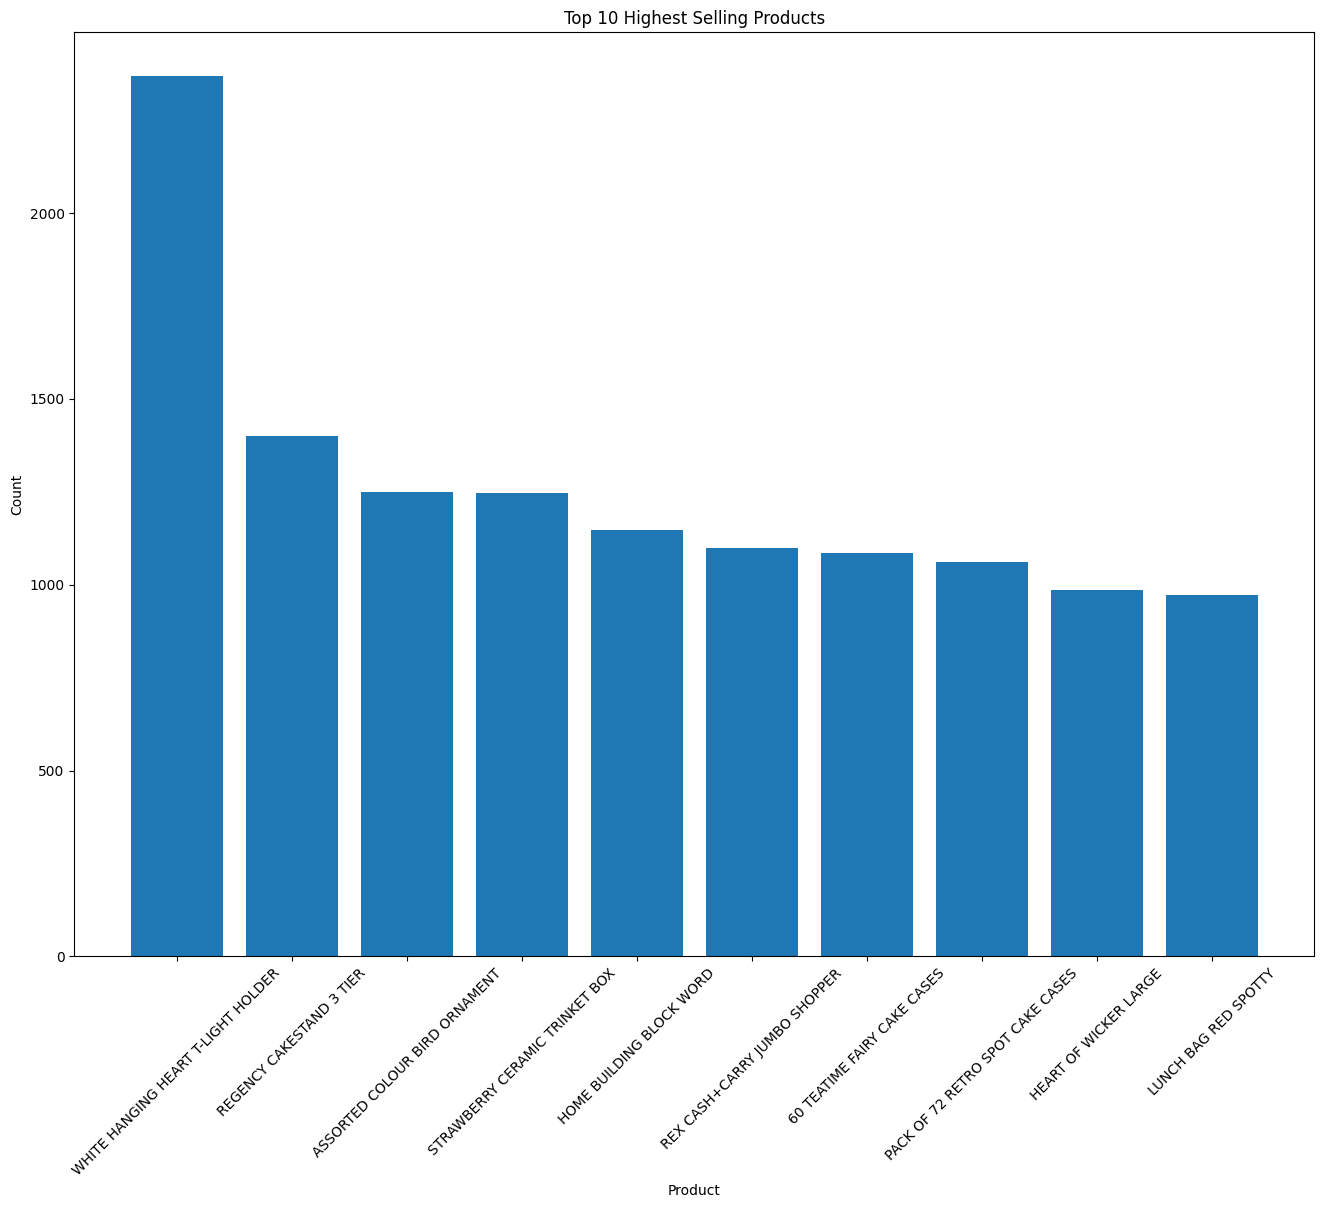

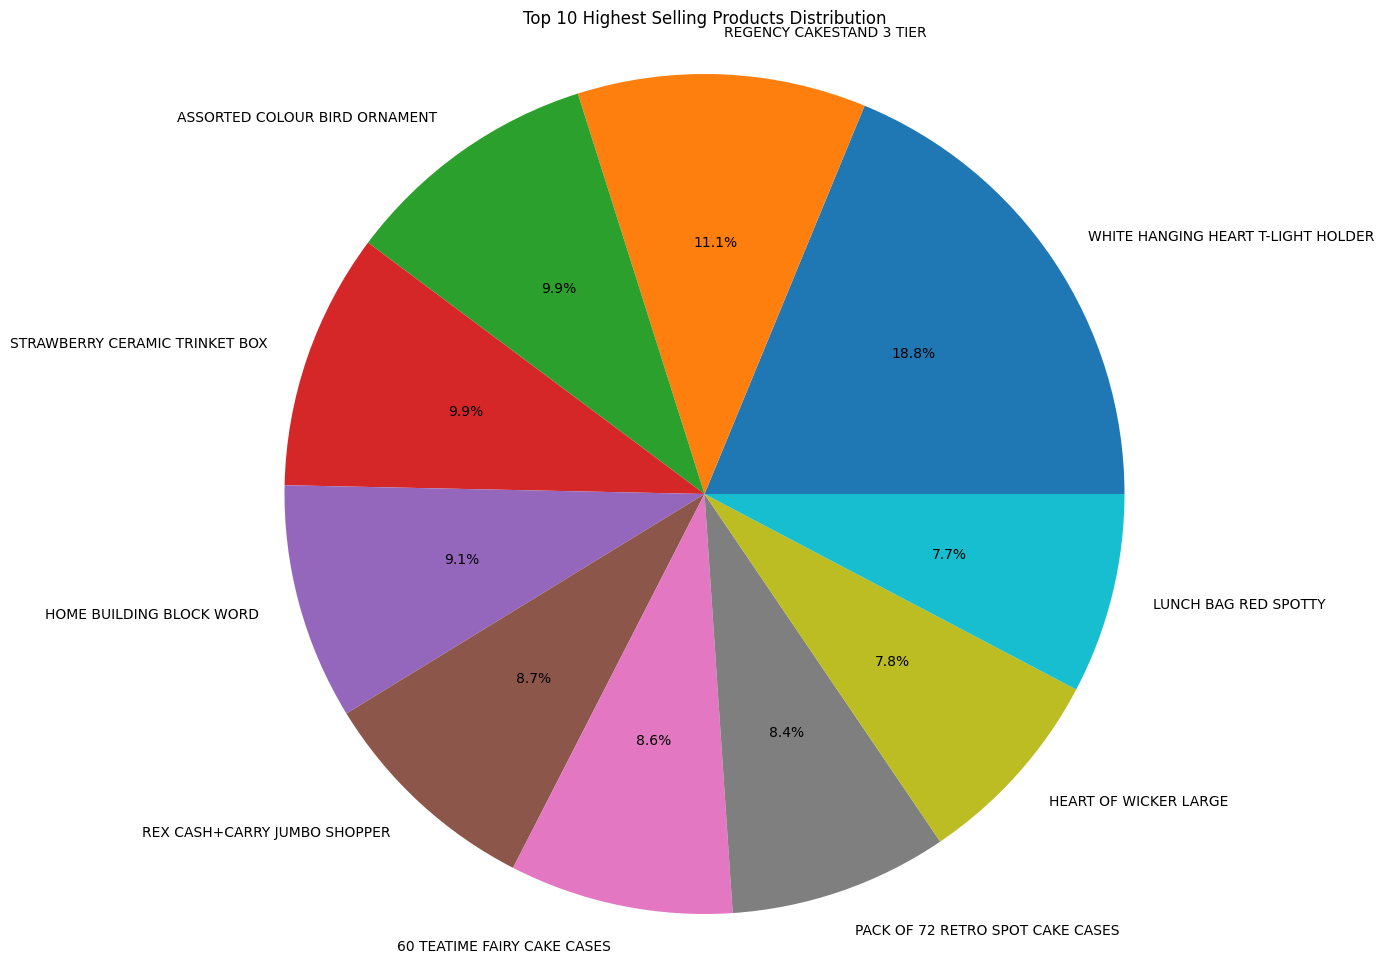

In [304]:
# Bar plot of highest selling products
N = 10  # Number of top products to display
top_products = sorted_df2.head(N)

plt.figure(figsize=(16, 12))
plt.bar(top_products['Description'], top_products['Count'])
plt.xlabel('Product')
plt.ylabel('Count')
plt.title(f'Top {N} Highest Selling Products')
plt.xticks(rotation=45)
plt.show()

# Pie chart of highest selling products
plt.figure(figsize=(14, 12))
plt.pie(top_products['Count'], labels=top_products['Description'], autopct='%1.1f%%')
plt.title(f'Top {N} Highest Selling Products Distribution')
plt.axis('equal')
plt.show()